In [7]:
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import seaborn as sns
sns.set_context('poster')
%matplotlib inline
reload(sa)
reload(sc)

<module 'neuraltda.simpComp' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/simpComp.pyc'>

# Reproducing graph ML Estimation from De domnico


In [186]:
# generate a random graph:
plink = 0.09
N = 200
adj = np.random.rand(N, N)
adj = (adj + adj.T)/2.0
adjData = (adj < plink).astype(int)

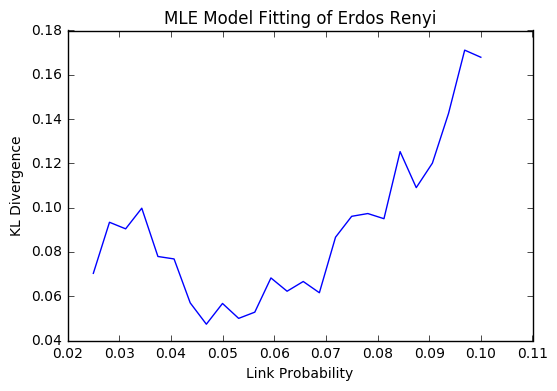

In [50]:
def loss(p, beta):
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
    Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Esample), 0)
    Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    rdata = sc.densityMatrix(Ldata, beta)
    return sc.KLdivergence(rdata, rsamp)

kl = []
ps = np.linspace(0.025, 0.1, 25)
for p in ps:
    kl.append(loss(p, 0.25))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

0.025
0.0265306122449
0.0280612244898
0.0295918367347
0.0311224489796
0.0326530612245
0.0341836734694
0.0357142857143
0.0372448979592
0.0387755102041
0.040306122449
0.0418367346939
0.0433673469388
0.0448979591837
0.0464285714286
0.0479591836735
0.0494897959184
0.0510204081633
0.0525510204082
0.0540816326531
0.055612244898
0.0571428571429
0.0586734693878
0.0602040816327
0.0617346938776
0.0632653061224
0.0647959183673
0.0663265306122
0.0678571428571
0.069387755102
0.0709183673469
0.0724489795918
0.0739795918367
0.0755102040816
0.0770408163265
0.0785714285714
0.0801020408163
0.0816326530612
0.0831632653061
0.084693877551
0.0862244897959
0.0877551020408
0.0892857142857
0.0908163265306
0.0923469387755
0.0938775510204
0.0954081632653
0.0969387755102
0.0984693877551
0.1


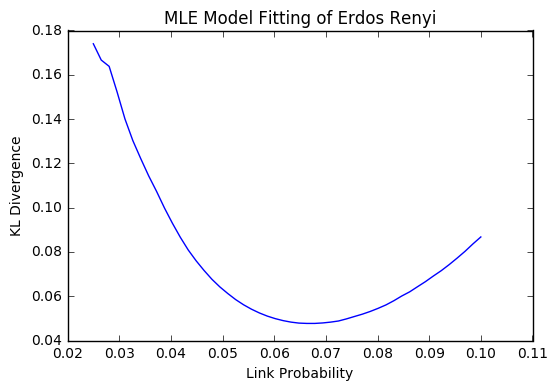

In [59]:
def loss(p, beta):
    
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
    Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Esample), 0)
    Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    rdata = sc.densityMatrix(Ldata, beta)
    return sc.KLdivergence(rdata, rsamp)

kl = []
kl_p = []
nsamples = 10
ps = np.linspace(0.025, 0.1, 50)
for p in ps:
    print(p)
    for n in range(nsamples):
        kl_p.append(loss(p, 0.25))
    kl.append(np.mean(kl_p))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

In [187]:
beta = 0.1
c = 0.25
Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 0)
rdata = sc.densityMatrix(Ldata, beta)
entData = sc.Entropy(rdata, beta)

#determine beta
f = lambda b: -sc.Entropy(rdata, b) / N - c*b
betastar = brentq(f, 0.001, 1.5)
betastar

0.15189116598734353

0.025
0.0265306122449
0.0280612244898
0.0295918367347
0.0311224489796
0.0326530612245
0.0341836734694
0.0357142857143
0.0372448979592
0.0387755102041
0.040306122449
0.0418367346939
0.0433673469388
0.0448979591837
0.0464285714286
0.0479591836735
0.0494897959184
0.0510204081633
0.0525510204082
0.0540816326531
0.055612244898
0.0571428571429
0.0586734693878
0.0602040816327
0.0617346938776
0.0632653061224
0.0647959183673
0.0663265306122
0.0678571428571
0.069387755102
0.0709183673469
0.0724489795918
0.0739795918367
0.0755102040816
0.0770408163265
0.0785714285714
0.0801020408163
0.0816326530612
0.0831632653061
0.084693877551
0.0862244897959
0.0877551020408
0.0892857142857
0.0908163265306
0.0923469387755
0.0938775510204
0.0954081632653
0.0969387755102
0.0984693877551
0.1


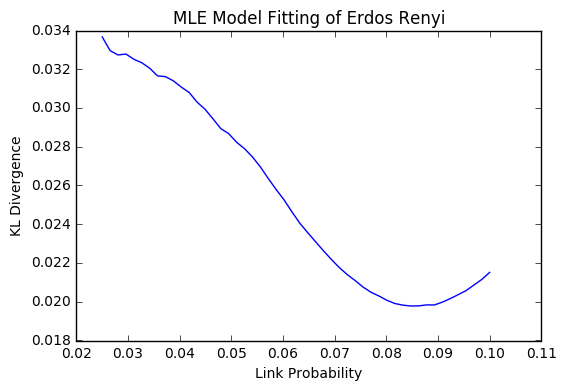

In [188]:
def loss(p, beta):
    N = 200
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Esample), 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    return sc.KLdivergence(rdata, rsamp)

kl = []
kl_p = []
nsamples = 10
ps = np.linspace(0.025, 0.1, 50)
for p in ps:
    print(p)
    for n in range(nsamples):
        kl_p.append(loss(p, betastar))
    kl.append(np.mean(kl_p))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

In [57]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.045
b = 0.15
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


In [301]:
nsamples2 = 10
def loss(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        
        Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Emodel), 1)
        Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 1)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    return np.mean(KLsave)

In [281]:
KL=[]
X = np.linspace(0.01, 0.1, 30)

for x in X:
    KL.append(loss(x, 0.15))

ValueError: operands could not be broadcast together with shapes (176,) (15,) 

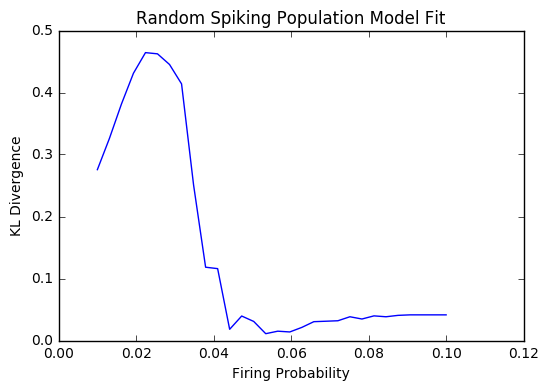

In [279]:
plt.plot(X, KL)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Random Spiking Population Model Fit')

In [137]:
ez = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
ey = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]])
ex = np.array([[0, 0, 0], [0, 0, 1], [0, -1, 0]])

In [157]:
plink = 0.5
N = 500
adjMats= []
lapMats = []
for n in range(3):
    adj = np.random.rand(N, N)
    w = np.random.randn(N, N)
    adj = (adj + adj.T)/2.0
    w = (w+w.T)/2.0
    adjData = (adj < plink).astype(int)
    adjData = np.multiply(adjData, w)
    adjMats.append(adjData)
    lapMats.append(sc.graphLaplacian(adjData))

In [159]:
def mat(i, j):
    return adjMats[0][i,j]*ex + adjMats[1][i,j]*ey + adjMats[2][i,j]*ez
def lap(i, j):
    return lapMats[0][i,j]*ex + lapMats[1][i,j]*ey + lapMats[2][i,j]*ez

In [58]:
nsamples2 = 25
def loss(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
        Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
        Lsamp = sc.laplacian(Dsamp, 1)
        Ldata = sc.laplacian(Ddata, 1)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
        m = np.mean(KLsave)
        std = np.std(KLsave)
        stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

In [59]:
KL=[]
KLerr = []
X = np.linspace(0.01, 0.1, 30)

for x in X:
    
    (m, stderr) = loss(x, 0.15)
    KL.append(m)
    KLerr.append(stderr)
    print(x)

0.01
0.0131034482759
0.0162068965517
0.0193103448276
0.0224137931034
0.0255172413793
0.0286206896552
0.031724137931
0.0348275862069
0.0379310344828
0.0410344827586
0.0441379310345
0.0472413793103
0.0503448275862
0.0534482758621
0.0565517241379
0.0596551724138
0.0627586206897
0.0658620689655
0.0689655172414
0.0720689655172
0.0751724137931
0.078275862069
0.0813793103448
0.0844827586207
0.0875862068966
0.0906896551724
0.0937931034483
0.0968965517241
0.1


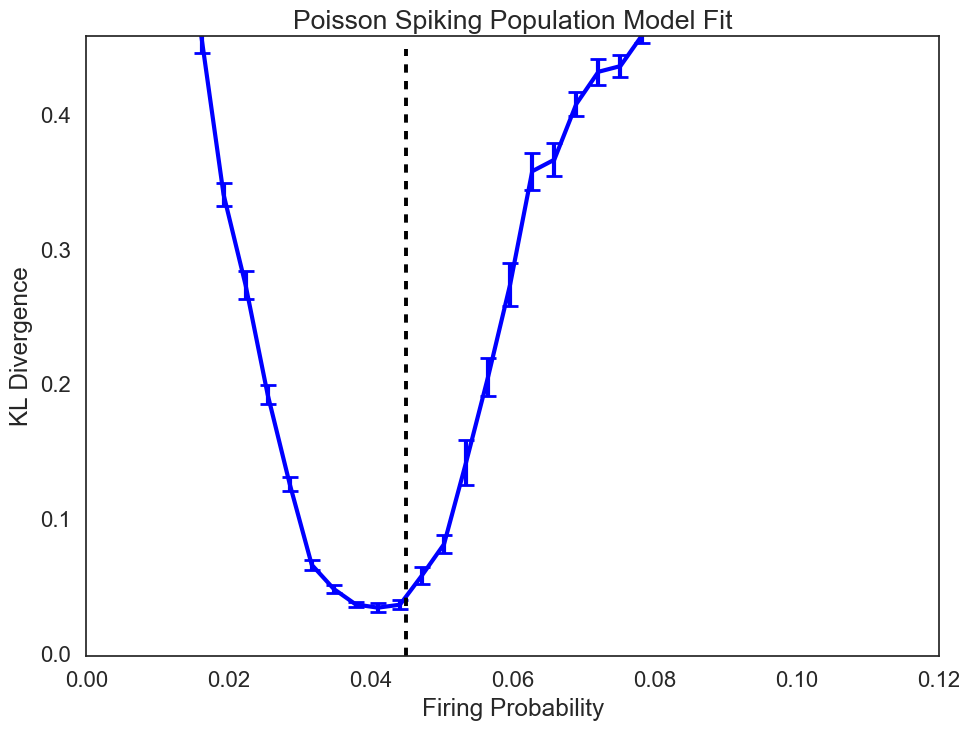

In [60]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [287]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.05
b = 0.15
probs = (a*np.ones((ncells, 1)))
nsamples = 2
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]
Emodel = SCGs[1]


In [290]:

Ecombined = sc.simplexUnion(Emodel, Edata)
Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
Lsamp = sc.laplacian(Dsamp, 0)
Ldata = sc.laplacian(Ddata, 0)
rsamp = sc.densityMatrix(Lsamp, beta)
        
rdata = sc.densityMatrix(Ldata, beta)

In [382]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 10
nwin = 1000
a = 0.02
b = 0.05
probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
nsamples = 1
samples = np.random.rand(2*ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)
np.random.shuffle(binMatsamples)



# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    mat = binMatsamples[:, :, ind]
    mat = np.random.permutation(mat.T)
    mat = mat.T
    print(mat.shape)
    msimps = sc.binarytomaxsimplex(binMat=mat, rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


(20, 1000)


In [383]:
d = 2
nsamples2 = 5
def loss(a, b, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
    KLsave=[]
    samples = np.random.rand(2*ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
        Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
        Lsamp = sc.laplacian(Dsamp, d)
        Ldata = sc.laplacian(Ddata, d)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    return np.mean(KLsave)

In [384]:
KL=[]
X = np.linspace(0.01, 0.1, 20)

for x in X:
    print(x)
    for y in X:
        KL.append(loss(x,y, 0.15))
KL = np.reshape(KL, (20,20))

0.01
0.0147368421053
0.0194736842105
0.0242105263158
0.0289473684211
0.0336842105263
0.0384210526316
0.0431578947368
0.0478947368421
0.0526315789474
0.0573684210526
0.0621052631579
0.0668421052632
0.0715789473684
0.0763157894737
0.0810526315789
0.0857894736842
0.0905263157895
0.0952631578947
0.1


In [375]:
KL

array([[ 0.58716417,  0.49597684,  0.4185173 ,  0.32122335,  0.31184622,
         0.22294113,  0.16867072,  0.14049595,  0.09439803,  0.08634849,
         0.05807257,  0.07567867,  0.05507429,  0.06018296,  0.05480656,
         0.04934224,  0.06199453,  0.06831266,  0.07685444,  0.06423916],
       [ 0.5029021 ,  0.42802398,  0.3170876 ,  0.27424499,  0.15834968,
         0.16238172,  0.09718018,  0.08271554,  0.05617979,  0.05238986,
         0.04477442,  0.03830572,  0.02882701,  0.03049245,  0.03934748,
         0.04324163,  0.04042189,  0.05738641,  0.06487843,  0.06921064],
       [ 0.39237126,  0.33704192,  0.28342283,  0.19798725,  0.11270156,
         0.09656021,  0.06902415,  0.03749275,  0.0251267 ,  0.02637011,
         0.03006907,  0.02935745,  0.04200162,  0.02862193,  0.04479642,
         0.03829549,  0.06117288,  0.06534109,  0.0833138 ,  0.08655202],
       [ 0.31077574,  0.24974085,  0.18872818,  0.11115229,  0.06919657,
         0.05549886,  0.03106405,  0.02762937,  

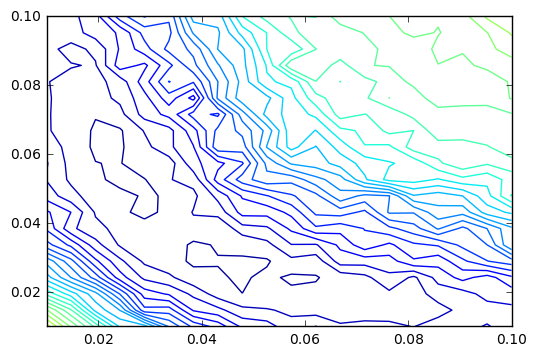

In [380]:
x, y = np.meshgrid(np.linspace(0.01, 0.1, 20), np.linspace(0.01, 0.1, 20))
levels = np.arange(0, 1, 0.025)
plt.contour(x, y, KL, levels=levels)

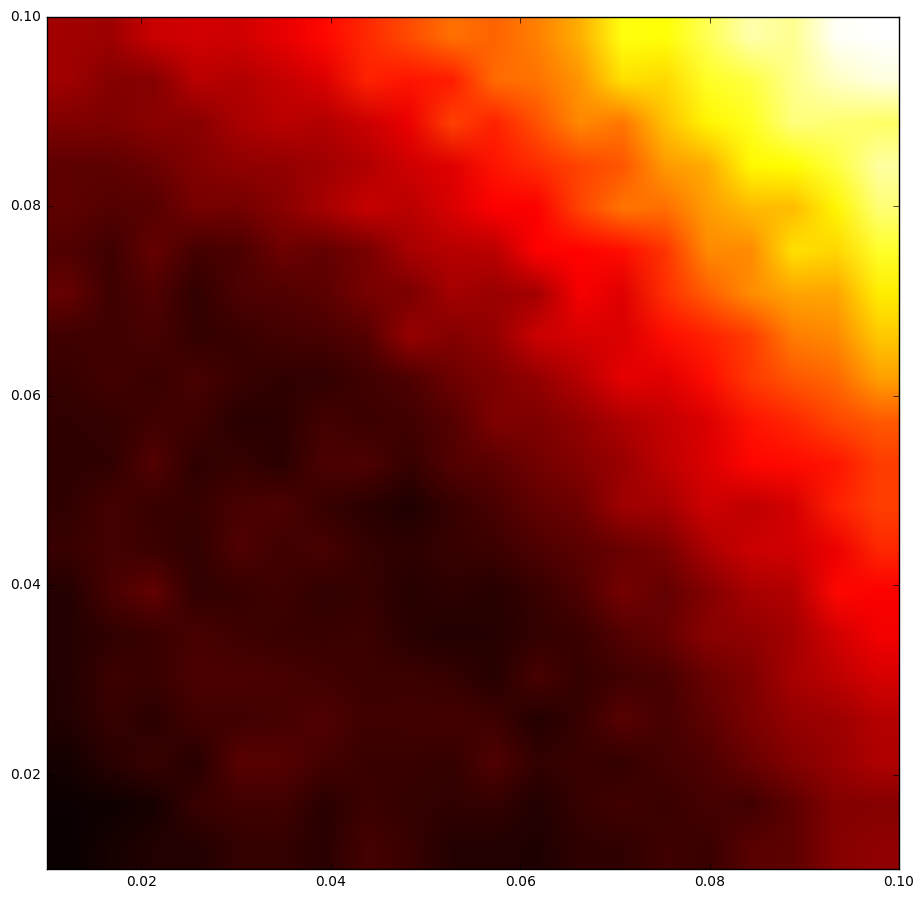

In [386]:
plt.figure(figsize=(11,11))
im = plt.imshow(KL, interpolation='bilinear', origin='lower',
                cmap='hot', extent=(0.01, 0.1, 0.01, 0.1))
#levels = np.arange(-1.2, 1.6, 0.2)
#CS = plt.contour(KL, origin='lower', levels=levels, linewidths=2,extent=(0.01, 0.1, 0.01, 0.1))

In [57]:
# try to reproduce given structure

targetMaxSimps = [(1,2), (2,3), (3,4), (4,5), (1,5)]

initweights = np.random.randn(5,5)/np.sqrt(5)

In [96]:
## setup parameters and state variables
T       = 50                  # total time to simulate (msec)
dt      = 0.125               # simulation time step (msec)
time    = np.arange(0, T+dt, dt) # time array
t_rest  = 0                   # initial refractory time
ncells = 5

## LIF properties
Vm      = np.zeros((ncells, len(time)))    # potential (V) trace over time
Rm      = 1                   # resistance (kOhm)
Cm      = 10                  # capacitance (uF)
tau_m   = Rm*Cm               # time constant (msec)
tau_ref = 0                   # refractory period (msec)
Vth     = 1                   # spike threshold (V)
V_spike = 0                 # spike reset (V)

## Stimulus
I       = 1.5                 # input current (A)

def spike(W, T):
    ## iterate over each time step
    dt      = 0.125               # simulation time step (msec)
    time    = np.arange(0, T+dt, dt) # time array
    Vm      = np.zeros((ncells, len(time)))    # potential (V) trace over time
    binmat = np.zeros((ncells, len(time)))
    for i, t in enumerate(time):
        if t > 0:
            Vm[:, i] = Vm[:, i-1] + (-Vm[:, i-1] + np.random.randn(5, 1)) / tau_m * dt
        if (Vm[:, i] >= Vth).any():
            binmat[:, i] = (Vm[:, i] >= Vth).astype(int)
            Vm[:, i] = np.dot(W, binmat[:, i]*Rm)
            Vm[:, i] += np.multiply(V_spike, (Vm[:, i] >= Vth).astype(int))
    return binmat, Vm

In [97]:
ps, Vm = spike(initweights, 50)
Vm

ValueError: could not broadcast input array from shape (5,5) into shape (5)

In [92]:
np.random.randn(ncells, 1)

array([[ 0.12635919],
       [ 0.08996373],
       [ 0.11467204],
       [ 0.47766722],
       [-1.16082666]])

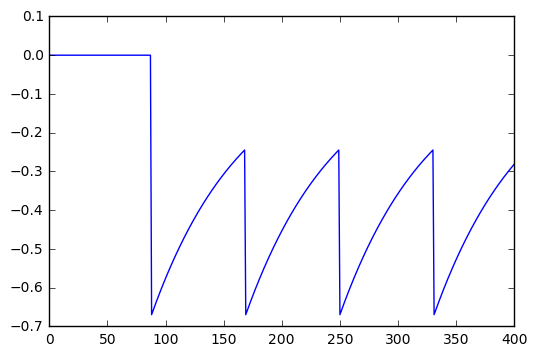

In [82]:
plt.plot(Vm[3, :])